[View in Colaboratory](https://colab.research.google.com/github/adounas/Reaction_Rates/blob/develop/Reaction_Rates.ipynb)

In [0]:
def clearall():
  all = [var for var in globals() if (var[:2], var[-2:]) != ("__", "__")]
  for var in all:
    del globals()[var]

In [0]:
clearall()

In [0]:
import tensorflow as tf
import numpy as np

In [0]:
x_names=['Pyr','Bic','Lac']          # names of components in the reaction associate with conecntration stored in x
In_Yr=[[1,0,0],[1,0,0],[0,0,1]]      # reactant ratios for each reaction
In_Yp=[[0,1,0],[0,0,1],[1,0,0]]      # product ratios for each reaction
In_dt=0.01                           # time lapse for each simulation step
TR = 1

x0=[0.1,0,0]                         # intial concentrations for reaction components
In_k=[3,6,2]                         # constant for each reaction
T1 = np.array([40,30,30])            # T1 relaxation time
alphap = [np.pi/90,np.pi/3,np.pi/3]  # flip angle

In [0]:
# TEST

x_names=['Pyr','Bic','Lac']          # names of components in the reaction associate with conecntration stored in x
reactants=[[1,0,0],[1,0,0],[0,0,1]]  # reactant ratios for each reaction
products=[[0,1,0],[0,0,1],[1,0,0]]   # product ratios for each reaction
In_dt=0.01                           # time lapse for each simulation step
TR = 1

x0=[0.1,0,0]                         # intial concentrations for reaction components
In_k=[3,10,2]                        # constant for each reaction
T1 = np.array([40,30,30])            # T1 relaxation time
alphap = [np.pi/90,np.pi/3,np.pi/3]  # flip angle

In [0]:
# Build tensorflow graph of single simulation step return the new concentration x after simulation step
def SimulationStep(x,In_Yr,In_Yp,In_k,In_dt):
    Yr  = tf.constant(In_Yr,tf.float32) # Reactant ratios for each reaction
    Yp  = tf.constant(In_Yp,tf.float32) # Product ratios for each reaction
    k   = tf.constant(In_k,tf.float32)  # Reaction constants for each reaction
    dt  = tf.constant(In_dt,tf.float32) # time lapse for each simulation step
    s1  = tf.pow(x,Yr)                  # x to the power of Yr
    s2  = tf.reduce_prod(s1,1)          # computes product of elements across dimensions
    r   = k*s2                          # Reaction rates
    s4  = tf.scalar_mul(dt,r)
    Yd  = Yp-Yr                         # Change in concentrations attribute to each reaction
    dxij= s4*tf.transpose(Yd)           # concentration changes each reaction in this step***
    dx  = tf.reduce_sum(dxij,1)         # sum of concentration changes from all reactions in this step***
    xp  = x+dx                          # New concentration after steps
    return(xp)

In [0]:
x=tf.placeholder(tf.float32)         # conentrations for each component this is placeholder and not variable/constant since we need to update it each cycle
xp=SimulationStep(x,In_Yr,In_Yp,In_k,In_dt) # Build tensorflow graph of single simulation step return the new concentration x after simulation step

sess = tf.Session()                  # start interactive session the difference between this and regular session is that interactive session established itself as the defult session hence you dont need to specify the session every time you use eval
sess.run(tf.global_variables_initializer()) # initialize variables
NumSteps=100                         # number of simulation step
Lapse=1                              # lapses between which data will be gathered and saved for graph
Tlapse=np.zeros(round(NumSteps/Lapse)+1,dtype=np.float32) # array containing the times in which the data were collected
x_sample=np.zeros([round(NumSteps/Lapse)+1,len(x_names)],dtype=np.float32) # sample x (concentrations)  during simulation
Tlapse[0]=0                          # Set initial simulation time as zero
x_sample[0]=x0                       # record initial commponent concentration

for i in range(NumSteps):            # Run simulation for NumSteps
    x0=sess.run(xp,feed_dict={x:x0}) # run numeric simulation step
    if (i%Lapse)==0:                 # collect the concentration in lapse of several simulation steps for graph (once every Lapse Steps)
        x_sample[round(i/Lapse)+1]=x0
        Tlapse[round(i/Lapse)+1]=i*In_dt

In [0]:
# adjust signal for T1 relaxation and excitation losses
for i in range(NumSteps+1):
  x_sample[i] = x_sample[i]*np.exp(-i/T1-(np.log(np.cos(alphap))/TR))

In [0]:
# concatenate all runs in one data vector
try:
  DataVec
except NameError:
  DataVec = np.array([x_sample])    

NewDataVec = np.expand_dims(x_sample, axis=0)
DataVec = np.append(DataVec, NewDataVec,0)

# concatenate all initial values in one target vector
try:
  TargetVec
except NameError:
  TargetVec = np.array([In_k])
  
NewTargetVec = np.expand_dims(In_k, axis=0)
TargetVec = np.append(TargetVec, NewTargetVec,0)

In [95]:
print(DataVec.shape)
print(TargetVec.shape)

(8, 101, 3)
(8, 3)


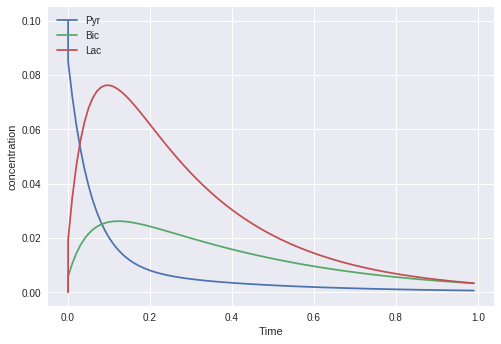

                Pyr, Bic, Lac
x0:             [0.00742109 0.04586797 0.04671092]
T1:             [40 30 30]
flip angles:    [0.03490658503988659, 1.0471975511965976, 1.0471975511965976]
                P-B, P-L, L-P
rate constants: [3, 10, 2]


In [96]:
PlotData = DataVec[-1]

import matplotlib.pyplot as plt
for c,label in zip(PlotData.swapaxes(0,1),x_names):
    plt.plot(Tlapse,c,label=label)
plt.legend(loc='upper left')
plt.xlabel("Time")
plt.ylabel("concentration")
plt.show()

print('                Pyr, Bic, Lac')
print('x0:            ',x0)
print('T1:            ',T1)
print('flip angles:   ',alphap)
print('                P-B, P-L, L-P')
print('rate constants:',In_k)

Prepare Network:
Initialize training and validation data

In [97]:
# Choose the first examples for training.
percentTraining = 0.7
nSamples = DataVec.shape[0]
nTrainingExamples = percentTraining * nSamples
nTrainingExamples = np.ceil(nTrainingExamples)
nValidationExamples = nSamples - nTrainingExamples

print(nSamples)
print(nTrainingExamples)
print(nValidationExamples)

8
6.0
2.0
